In [3]:
#%matplotlib inline

In [4]:
import random
import time
import math
import string

from tqdm import tqdm
from urllib.request import urlopen
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable

# Making the code device-agnostic
device = 'cuda' if torch.cuda.is_available() else 'cpu'

random.seed(10)


# Task 1

## Import and format text

In [5]:

all_characters = string.printable
n_characters = len(all_characters)

# Reading and un-unicode-encoding data
def read_file(url):
    file = urlopen(url).read().decode()
    return file, len(file)

# Turning a string into a tensor
def char_tensor(string):
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
        try:
            tensor[c] = all_characters.index(string[c])
        except:
            continue
    return tensor

# Readable time elapsed
def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


## Model creation

In [6]:
class CharRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, model="gru", n_layers=1):
        super(CharRNN, self).__init__()
        self.model = model.lower()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers

        self.encoder = nn.Embedding(input_size, hidden_size)
        if self.model == "gru":
            self.rnn = nn.GRU(hidden_size, hidden_size, n_layers)
        elif self.model == "lstm":
            self.rnn = nn.LSTM(hidden_size, hidden_size, n_layers)
        self.decoder = nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden):
        batch_size = input.size(0)
        encoded = self.encoder(input)
        output, hidden = self.rnn(encoded.view(1, batch_size, -1), hidden)
        output = self.decoder(output.view(batch_size, -1))
        return output, hidden

    def forward2(self, input, hidden):
        encoded = self.encoder(input.view(1, -1))
        output, hidden = self.rnn(encoded.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))
        return output, hidden

    def init_hidden(self, batch_size):
        if self.model == "lstm":
            return (torch.zeros(self.n_layers, batch_size, self.hidden_size).to(device),
                    torch.zeros(self.n_layers, batch_size, self.hidden_size).to(device))
        return torch.zeros(self.n_layers, batch_size, self.hidden_size).to(device)

In [7]:
batch_size = 100
learning_rate = 0.01
n_epochs = 2000
chunk_len = 200

decoder = CharRNN(
    input_size=n_characters,
    hidden_size=50,
    output_size=n_characters,
    model="lstm",    # "gru" or "lstm"
    n_layers=2,
).to(device)

decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

# Tiny Shakespear dataset
url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
file, file_len = read_file(url)


## Define functions

In [8]:

def random_training_set(chunk_len, batch_size):
    inp = torch.LongTensor(batch_size, chunk_len)
    target = torch.LongTensor(batch_size, chunk_len)
    for bi in range(batch_size):
        start_index = random.randint(0, file_len - chunk_len)
        end_index = start_index + chunk_len + 1
        chunk = file[start_index:end_index]
        inp[bi] = char_tensor(chunk[:-1])
        target[bi] = char_tensor(chunk[1:])
    
    #Add to device
    inp = inp.to(device)
    target = target.to(device)
    
    return inp, target


def train(inp, target):
    hidden = decoder.init_hidden(batch_size)
    decoder.zero_grad()
    loss = 0

    for c in range(chunk_len):
        output, hidden = decoder(inp[:,c], hidden)
        loss += criterion(output.view(batch_size, -1), target[:,c])

    loss.backward()
    decoder_optimizer.step()

    return loss.data / chunk_len    


def generate(decoder, prime_str='A', predict_len=100, temperature=0.8, device=device):
    hidden = decoder.init_hidden(1)
    prime_input = Variable(char_tensor(prime_str).unsqueeze(0))

    prime_input = prime_input.to(device)
    predicted = prime_str

    # Use priming string to "build up" hidden state
    for p in range(len(prime_str) - 1):
        _, hidden = decoder(prime_input[:,p], hidden)
        
    inp = prime_input[:,-1]
    
    for p in range(predict_len):
        output, hidden = decoder(inp, hidden)
        
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]

        # Add predicted character to string and use as next input
        predicted_char = all_characters[top_i]
        predicted += predicted_char
        inp = char_tensor(predicted_char).unsqueeze(0).to(device)

    return predicted

## Train model

Training for 2000 epochs...


  5%|▌         | 100/2000 [00:42<13:40,  2.31it/s]

 42s (100 5%) 2.3060]

Wher orwand fom hen brorife souch arate the foeg he chast By un urscaghle lopes thee ry oll cy the id  




 10%|█         | 200/2000 [01:22<12:09,  2.47it/s]

 22s (200 10%) 2.0332]

Whe us the is that sey prakner on you thas

Bamecfhir heor corres blord and seis dor?



KENGTIRS:

Wore,  




 15%|█▌        | 300/2000 [02:01<11:24,  2.48it/s]

 1s (300 15%) 1.8936]

Whas the what leort's blated.



CLIRF ICHIO:

Where thoude him me it thive opes

I on and gould of cable  




 20%|██        | 400/2000 [02:39<10:52,  2.45it/s]

 39s (400 20%) 1.7997]

Whow we we porbiste he riderit, gat! it so died

Op in whow, there 'ty now agale, so dosess,

The sweedi 




 25%|██▌       | 500/2000 [03:17<09:52,  2.53it/s]

 17s (500 25%) 1.7434]

Who prace, I wrow I brost he put on the to with live,

And from the dalt, on Romeich for the come here

 




 30%|███       | 600/2000 [03:55<09:34,  2.44it/s]

 55s (600 30%) 1.6912]

What this forcout be as drock a father, and grace the mencings vore; the in a unvicesfar himfort who t 




 35%|███▌      | 700/2000 [04:33<09:03,  2.39it/s]

 33s (700 35%) 1.6581]

Whatk to have solly back;

Iy rike that son, fit it you here outh bones the day the couch.

To-proved wa 




 40%|████      | 800/2000 [05:13<07:57,  2.51it/s]

 13s (800 40%) 1.6452]

Whis hence of I clopess: I have do grought

Marwiling, and wison, nor brown

And. And I the pring:

And t 




 45%|████▌     | 900/2000 [05:51<07:24,  2.48it/s]

 51s (900 45%) 1.6221]

Whas country her your lost of his say on mean,

What you undate wesklards have heriens;

Where out do th 




 50%|█████     | 1000/2000 [06:29<06:50,  2.43it/s]

 29s (1000 50%) 1.6205]

Whirgeral honory or the make fink

Is shall chum is the scongue

Lonce, foul so the tamel: daughter doul 




 55%|█████▌    | 1100/2000 [07:08<06:11,  2.42it/s]

 8s (1100 55%) 1.6084]

What compost the onest him did the brother, he? Sirn perforge at in the all to plaughtion?

Go long of  




 60%|██████    | 1200/2000 [07:47<05:35,  2.38it/s]

 47s (1200 60%) 1.5940]

Whe his deper that he brongeren: what so,

Of win to get of my sown mine.



Nurse:

The part this truth i 




 65%|██████▌   | 1300/2000 [08:26<04:58,  2.35it/s]

 26s (1300 65%) 1.5552]

When air cratter for thee all the such in we fair is it your

Shall since at a fortus

that a blood

The  




 70%|███████   | 1400/2000 [09:05<04:16,  2.34it/s]

 5s (1400 70%) 1.5904]

Whas in pation on viollause,

We spireter of your only this bood end Gelless.



RIVERS:

That you by the  




 75%|███████▌  | 1500/2000 [09:43<03:18,  2.51it/s]

 43s (1500 75%) 1.5718]

Wher lord and a shall be that grave prove not saycue's not warruching.

Well to life unto the hatrenish 




 80%|████████  | 1600/2000 [10:21<02:41,  2.48it/s]

 21s (1600 80%) 1.5405]

Whas thou stard, my privrething the friend daint pray.



GLOUCESTER:

Yet may point of say at than I tha 




 85%|████████▌ | 1700/2000 [10:59<02:04,  2.41it/s]

 59s (1700 85%) 1.5517]

What be service, is the like strange;

And the and the tear it the leaning of her did my heart

The grea 




 90%|█████████ | 1800/2000 [11:38<01:20,  2.48it/s]

 38s (1800 90%) 1.5385]

Which self.

The good villable adigtiinsted for his anbutio?



SICINIUS:

That the waed 'twine.

Uplort Au 




 95%|█████████▌| 1900/2000 [12:16<00:39,  2.50it/s]

 16s (1900 95%) 1.5663]

Whas the reposang shall be have unton

That we contain a like me: henced him, so subpether.



POMPEY:

Si 




100%|██████████| 2000/2000 [12:54<00:00,  2.58it/s]

 53s (2000 100%) 1.5109]

What doth fortle, why end't and at a murse, when?



CAFPELIA:

To more smore to not be true, thou should 




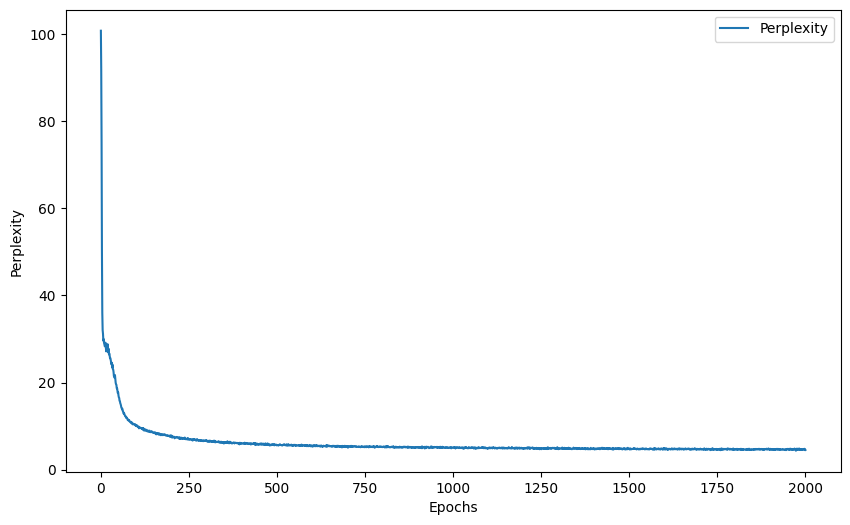

In [7]:
start = time.time()
all_perplexity = []
print_every = 100

print("Training for %d epochs..." % n_epochs)
for epoch in tqdm(range(1, n_epochs + 1)):
    loss = train(*random_training_set(chunk_len, batch_size))
    
    #Perplexity
    perplexity = torch.exp(loss)
    all_perplexity.append(perplexity.cpu())

    if epoch % print_every == 0:
        print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))
        print(generate(decoder, 'Wh', 100, device=device), '\n')
        
# Plot the perplexity per epoch
plt.figure(figsize=(10,6))
plt.plot(range(1,n_epochs+1), all_perplexity, label='Perplexity')

plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Perplexity')
plt.show()


# Task 2

In [8]:
for i in range(5):
    seq = ''.join(random.choices(all_characters, k=5))
    print(f'Output {i+1}:')
    print(generate(decoder, seq, 100, device=device), '\n')


Output 1:

	Lstden ouh there to the dead's good baring gives me: unto me a know:

Ast is no since now, if a slave mis 



Output 2:

5\bQait who dodize-wisted 'twere,

Your mall a fair here King our father,--soult stays,

I'll liver, and t 



Output 3:

9R.U( Iclather oppaids.



PARIS:

Ne a man world slaughters,

It commons so we end the daint and were belcom 



Output 4:

M^cFlece the ramber a patispilence, for your consent till shardstant? what would be let of the while

But  



Output 5:

'}; men, all can night you waters!



VOLUMNIA:

I would by the master wears, my lords with him:

I thine t 




# Task 3

In [9]:
seq_list = ["The", "What is", "Shall I give", "X087hNYB BHN BYFVuhsdbs"]

for i, seq in enumerate(seq_list):
    print(f'Output {i+1}:')
    print(generate(decoder, seq, 100, device=device), '\n')

Output 1:

The would what we not all here,

Where to the lible our face in the change man.

Hark say sleep the more  



Output 2:

What is the common these, but, that you

ford. Come the things this plucks of end?



LUCIO:

Madmen say, if Go 



Output 3:

Shall I give, help and shows will cure

Is base for the betters doth bessent we have my brether to-mut;

The repok 



Output 4:

X087hNYB BHN BYFVuhsdbse

And my lives war is their nuts ty the good will not?



KING EDWARD IV:

Why was thee recing my crown 




# Optional tasks (still some TBD):

### 4.1 Question 1: What are Language Models? Where and how are Language Models used?
A language model can recognize, summarize, translate, predict and generate text and other content. This is done by training on exisiting text. Some examples of useful applications are chatbots and AI assistants, but also models that work with medicine and chemistry such as protein folding.
### 4.2 Question 2: How can you use a trained Char-RNN model as a Character Level Language Model?
By providing the model with large amount of text data, it can learn probabilies of the next character of a sequence. Hence you first have to provide a seed as a start, but then the model will continue generating text.
### 4.3 Question 3: How can you train a Word Level Language Model?
Instead of training on characted sequence, the model will be provided with entire words and so it can calculate probabilities of words following instead of characters.
### 4.4 Question 4: Formally describe the inference model that an RNN trained to predict the next word represents?
The next word of a sequence is inferred by a probability distribution that is dependent on previous words. So formally word x+1 is dependent on word 1 to x, where the most likely word is selected.
### 4.5 Question 5: How will you generate the "probability of existence" of an input sequence of words, given a trained RNN Language Model?
Perplexity is used to evaluate the model and can then be used to generate the "probability of existence".

# Task 4

In [9]:
import torchtext

from torchtext.data import get_tokenizer

In [10]:
# Initialize tokenizer
tokenizer = get_tokenizer("basic_english")

# Create a disctionary of all unique words
def tokenize(string):
    #file_words = tokenizer(file)
    tokens = string.split(' ')
    return tokens

file_words = tokenize(file)
words = set(file_words)
n_words = len(words)
token2word = {}
word2token = {}
for i, word in enumerate(words):
    token2word[i] = word
    word2token[word] = i

# Return string from tensor of indices
def tensor2text(tensor, dict):
    return ' '.join([dict[index.item()] for index in tensor])

# Return tensor with indices from string
def text2tensor(text_list, dict):
    tensor = torch.Tensor([dict[token] for token in text_list])
    return tensor.int()


In [17]:
# Testing
index_tensor = torch.tensor([1, 3, 5])
text = ['sucking', 'alteration?', 'chivalrous']

print(tensor2text(index_tensor, token2word))
print(text2tensor(text, word2token))


interchange merrily they


KeyError: 'alteration?'

In [12]:
batch_size = 100
learning_rate = 0.01
n_epochs = 2000
chunk_len = 200

decoder = CharRNN(
    input_size=n_words,
    hidden_size=50,
    output_size=n_words,
    model="lstm",    # "gru" or "lstm"
    n_layers=2,
).to(device)

decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

# Tiny Shakespear dataset
url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
file, file_len = read_file(url)

In [13]:
def random_training_set(chunk_len, batch_size):
    inp = torch.LongTensor(batch_size, chunk_len)
    target = torch.LongTensor(batch_size, chunk_len)
    for bi in range(batch_size):
        start_index = random.randint(0, len(file_words) - chunk_len - 1)
        end_index = start_index + chunk_len + 1
        chunk = file_words[start_index:end_index]
        inp[bi] = text2tensor(chunk[:-1], word2token)
        target[bi] = text2tensor(chunk[1:], word2token)
    
    #Add to device
    inp = inp.to(device)
    target = target.to(device)
    
    return inp, target


def train(inp, target):
    hidden = decoder.init_hidden(batch_size)
    decoder.zero_grad()
    loss = 0

    for c in range(chunk_len):
        output, hidden = decoder(inp[:,c], hidden)
        loss += criterion(output.view(batch_size, -1), target[:,c])

    loss.backward()
    decoder_optimizer.step()

    return loss.data / chunk_len    


def generate(decoder, prime_text='The', predict_len=100, temperature=0.8, device=device):
    hidden = decoder.init_hidden(1)
    prime_tokens = tokenize(prime_text)
    predicted_tensor = text2tensor(prime_tokens, word2token).to(device)
    prime_input = predicted_tensor.unsqueeze(0)

    # Use priming words to "build up" hidden state
    for p in range(len(prime_tokens) - 1):
        _, hidden = decoder(prime_input[:,p], hidden)
    
    inp = prime_input[:,-1]
    
    for p in range(predict_len):
        output, hidden = decoder(inp, hidden)
        
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)

        # Add predicted word to tensor and use as next input
        inp = top_i
        predicted_tensor = torch.cat((predicted_tensor, top_i), 0)
    
    predicted = tensor2text(predicted_tensor, token2word)

    return predicted

In [14]:
start = time.time()
all_perplexity = []
print_every = 20

print("Training for %d epochs..." % n_epochs)
for epoch in tqdm(range(1, n_epochs + 1)):
    loss = train(*random_training_set(chunk_len, batch_size))
    
    #Perplexity
    perplexity = torch.exp(loss)
    all_perplexity.append(perplexity.cpu())

    if epoch % print_every == 0:
        print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))
        print(generate(decoder, 'The the', 100, device=device), '\n')
        
# Plot the perplexity per epoch
plt.figure(figsize=(10,6))
plt.plot(range(1,n_epochs+1), all_perplexity, label='Perplexity')

plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Perplexity')
plt.show()

Training for 2000 epochs...


  1%|          | 20/2000 [00:08<11:32,  2.86it/s] 

 8s (20 1%) 8.2782]
The the much
more I shall the for the to fearful not not are your the not the to blood is end it clear'd
Of thus the the her is the we with you this I Servant:
Madam, have shields. Master of to with to holy as of will of of with this to as like what him;
You that of and the am of thy waves a to thy to the like me bow'd way a that the with the his but a she to the my go rid of to with thou my man I for thou of hath woe the but my be, 



  2%|▏         | 40/2000 [00:15<11:40,  2.80it/s]

 15s (40 2%) 8.0901]
The the know little advised to be I'll in resolve.

BONA:
Your no be little of come your father, live million wearisome,
And so, noble with thou to-day;
The it, never a must I to a let the the in it will my leave a this, had nearness before and to my with
all.

ESCALUS:
Look heads the rotten for may in I lives my sir.

ESCALUS:
Troth, our that for belike, did fares ours.

ANTIGONUS:
And you the king this the and at I hath is a my things come his than of and to my are a I God's to your comes the is thou with you not gentle is, of 



  2%|▏         | 43/2000 [00:16<12:33,  2.60it/s]


KeyboardInterrupt: 

In [19]:
print(generate(decoder, ['The'], 100, device=device), '\n')
print(generate(decoder, ['.'], 100, device=device), '\n')
print(generate(decoder, ['which is,'], 100, device=device), '\n')
print(generate(decoder, ['blah blah blah'], 100, device=device), '\n')


The duke.



KING EDWARD IV:

Why, fair is him

To Bolingbroke.



QUEEN:

So, Green, thou comest as it hath been a kind of you.



NORTHUMBERLAND:

Why, is out and sold this goodly offer.



ROMEO:

Bid him not a grave

As that mark'd know'st with kind of rubs,

And in thy kindness' date.



KING RICHARD II:

We this Clifford, at the fearful brows do out-pray manner is the officers.



KING HENRY VI:

In God's name, spies thine. Thou art like not not know

The A story within, to speak that you shall be nearest,

Will sleep thee, canst, must were so looks shall bear my father off the honest VINCENTIO:

Angelo,

There of hate,

Between our inventions speak in heaven and all 




KeyError: '.'